In [1]:
import os
os.chdir('..')

In [2]:
import json
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

figures_folder = '../figures/'
results_folder = './server/parameters/results/'

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [48]:
tmp1 = json.load(open(results_folder + 'parameters_Full1.json'))
tmp2 = json.load(open(results_folder + 'parameters_Full2.json'))

In [64]:
for k in tmp1.keys():
    print(k)
    if k == 'base':
        print(len(tmp1[k]['time']))
    else:
        asd = tmp1[k].keys()
        for a in asd:
            print('  {}'.format(len(tmp1[k][a]['time'])))
            
    print('\n')

base
20


thresh_upd
  20
  20
  20
  20
  20
  20
  20
  20
  20
  20


count_upd
  20
  20
  20
  20
  20
  20
  20
  20
  20
  20
  14




In [61]:
asd

array(dict_keys(['0.1', '0.2', '0.5', '1', '2', '5', '10', '20', '50', '100']),
      dtype=object)

In [49]:
tmp1.keys()

dict_keys(['base', 'thresh_upd', 'count_upd'])

In [33]:
tmp = tmp1.copy()

for k in tmp2.keys():
    tmp[k] = tmp2[k]

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'])

In [34]:
with open(results_folder + 'parameters_Full.json', 'w') as outfile:
    json.dump(tmp, outfile)

In [35]:
params = ['thresh_upd', 'count_upd', 'window', 'factor_upd', 'perc_hybrid', 'stop_crit']

str_params = {
    'thresh_upd': '$\Delta$ [%]',
    'count_upd': '$C$',
    'window': '$W$',
    'factor_upd': '$\\tau$',
    'perc_hybrid': '$\Delta_H$ [%]',
    'stop_crit': '$\\varepsilon$'
}

base_param = {'perc_hybrid': 30, 'thresh_upd': 1, 'count_upd': 2, 'window': 10, 'factor_upd': 2, 'stop_crit': 1e-6}

In [36]:
def to_str(k):
    
    if k == 0.0:
        return "0"
    elif k < 1 or not (k).is_integer():
        return str(k)
    else:
        return str(int(k))

0: -67925.58838611584
5: -67925.58838606262
10: -67925.58838607796
15: -67925.58838604703
20: -67925.58838609021
25: -67925.58838607026
30: -67925.58838607761
35: -67925.58838602691
40: -67925.58838607608
45: -67925.58838605689
50: -67925.58838607077
55: -67925.58838600613
60: -67925.5883860698
65: -67925.58838604242
70: -67925.58838611617
75: -67925.58838600991
80: -67925.5883860592
85: -67925.58838608846
90: -67925.58838601832
95: -67925.5883861214
100: -67925.5883860844
0: -55712.99144223113
5: -55712.99144226195
10: -55712.99144221678
15: -55712.99144221607
20: -55712.99144234598
25: -55712.99144217862
30: -55712.99144231258
35: -55712.991442298764
40: -55712.99144221181
45: -55712.99144220238
50: -55712.9914422081
55: -55712.99144225537
60: -55712.991442241255
65: -55712.99144216904
70: -55712.99144220709
75: -55712.991442215935
80: -55712.991442193765
85: -55712.99144216592
90: -55712.991442237355
95: -55712.99144232461
100: -55712.99144219357


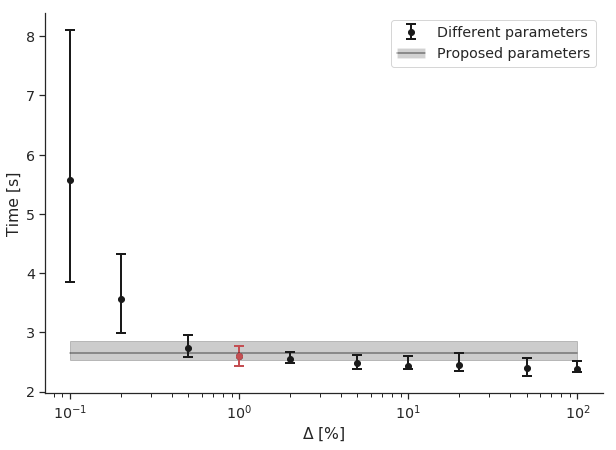

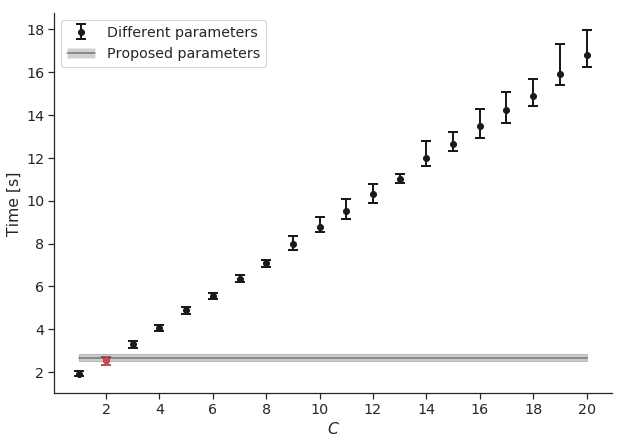

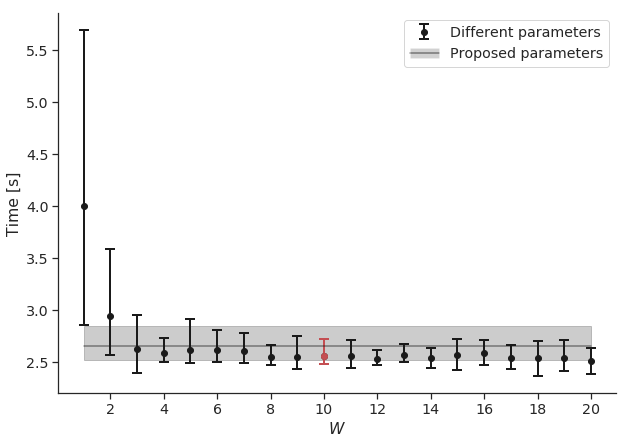

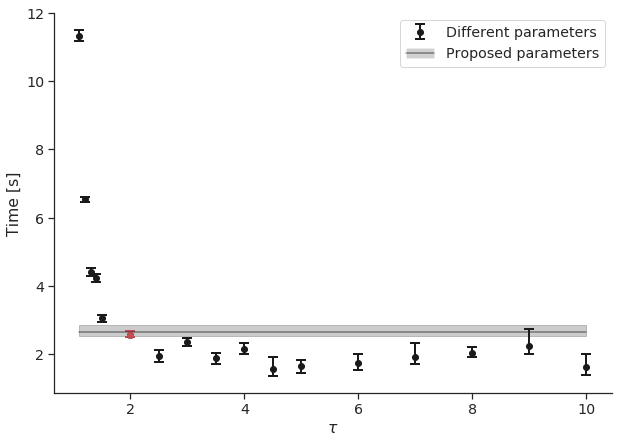

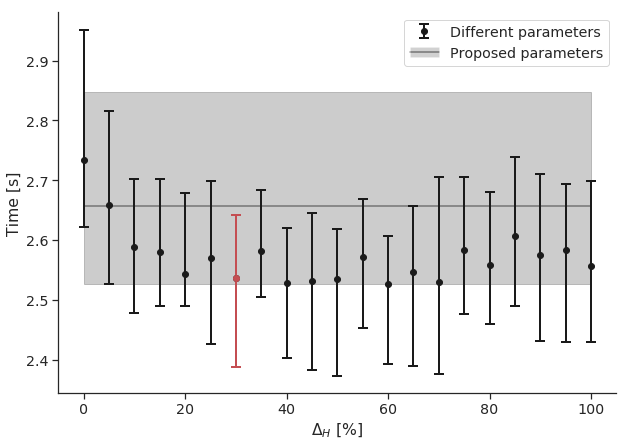

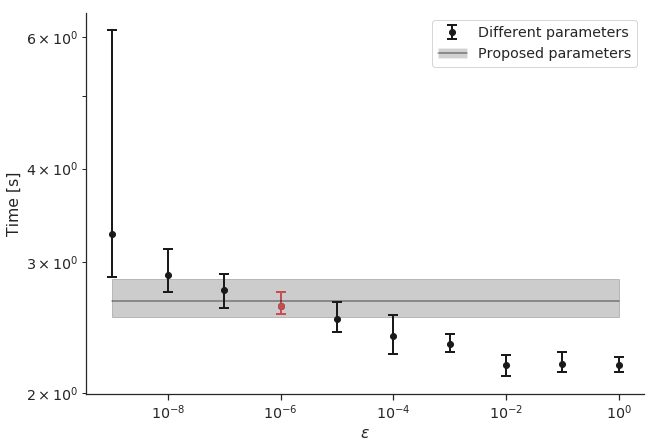

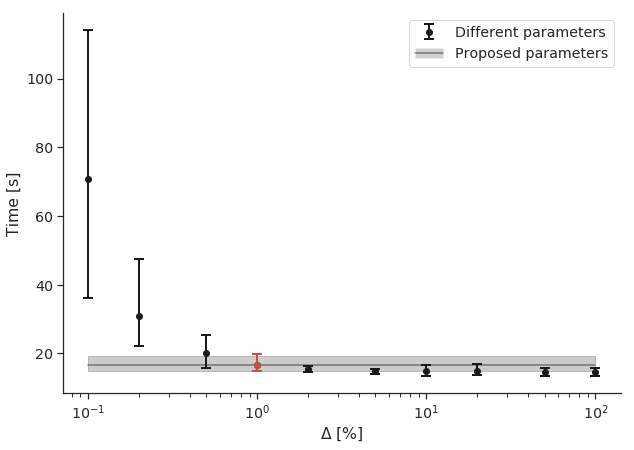

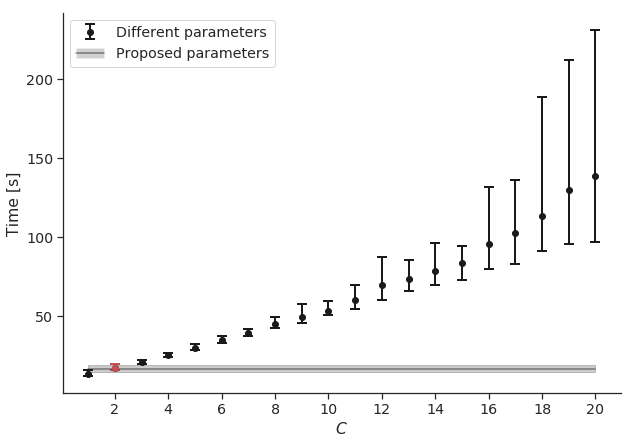

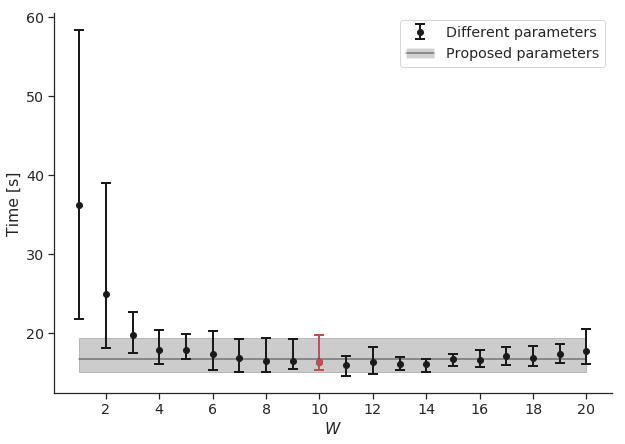

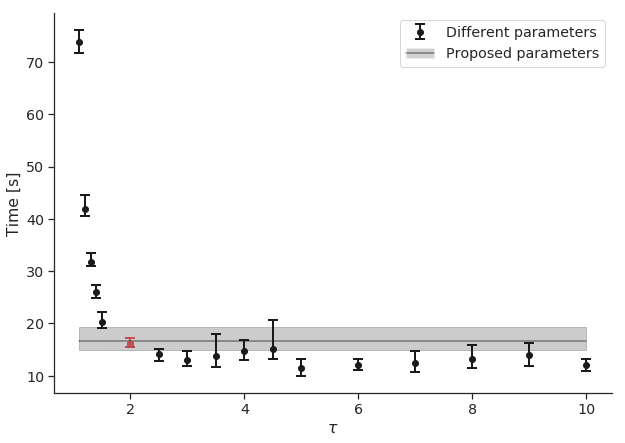

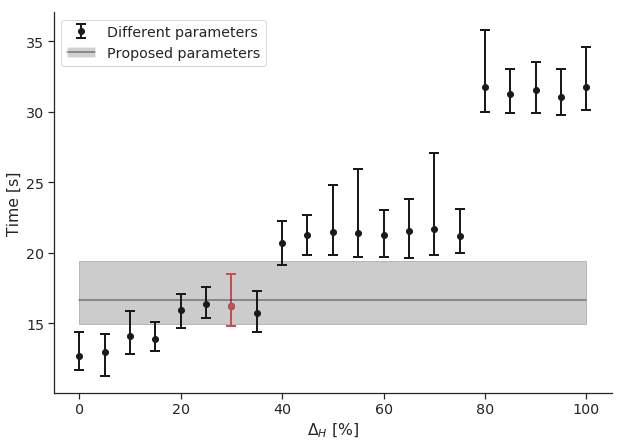

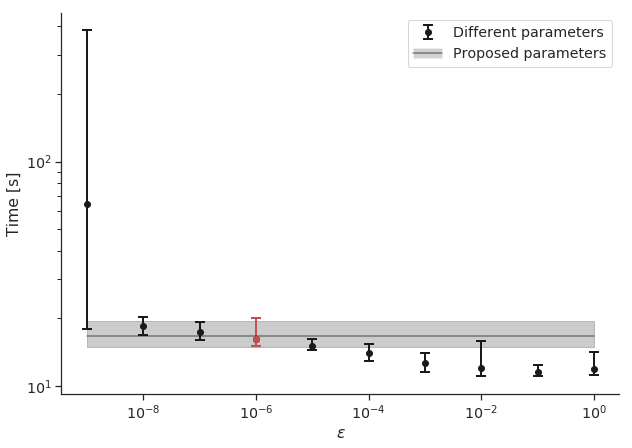

In [47]:
for model in ['DC', 'RR']:
    file = 'parameters_' + model + '.json'
    
    res = json.load(open(results_folder + file))
    
    time = res['base']['time']

    up = np.percentile(time, 97.5)
    down = np.percentile(time, 2.5)
    avg = np.mean(time)

    for p in params:
        
        if p == 'perc_hybrid':
            for key in res[p].keys():
                print(key + ': {}'.format(np.mean(res[p][key]['LL'])))
                
        tmp = res[p]

        keys = list(map(float, tmp.keys()))
        keys.sort()

        if p == 'stop_crit':
            func = lambda x: str(x)
        else:
            func = lambda x: to_str(x)

        err_down = [np.mean(tmp[func(k)]['time'])-np.percentile(tmp[func(k)]['time'], 2.5) for k in keys]
        err_up = [np.percentile(tmp[func(k)]['time'], 97.5)-np.mean(tmp[func(k)]['time']) for k in keys]
        err_avg = [np.mean(tmp[func(k)]['time']) for k in keys]

        plt.figure(figsize=(10, 7), frameon=False)

        sns.set_context("paper")
        sns.set(font_scale = 1.3)
        sns.set_style("white", {
            "font.family": "sans-serif",
            "font.serif": ['Helvetica'],
            "font.scale": 2
        })
        sns.set_style("ticks", {"xtick.major.size": 4,
                                "ytick.major.size": 4})

        ax = plt.subplot(111)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        p1 = plt.errorbar(keys, err_avg, yerr=[err_down, err_up], fmt='o', elinewidth=2, capthick=2, capsize=5, color='k')

        idx = keys.index(base_param[p])
        plt.errorbar(keys[idx], err_avg[idx], yerr=[[err_down[idx]], [err_up[idx]]], fmt='o', elinewidth=2, capthick=2, capsize=5, color='r')

        p2 = plt.fill_between([keys[0], keys[-1]], [down, down], [up, up], color='black', alpha=0.2)
        p3 = plt.plot([keys[0], keys[-1]], [avg, avg], 'k-', alpha=0.5)
        p4 = plt.fill(np.NaN, np.NaN, 'k', alpha=0.2)

        plt.xlabel(str_params[p])
        plt.ylabel('Time [s]')
        leg = plt.legend([p1, (p3[0], p4[0])], ['Different parameters', 'Proposed parameters'], frameon=True)  

        if p in ['thresh_upd', 'stop_crit']:
            plt.xscale('log')

        if p in ['stop_crit']:
            plt.yscale('log')

        if p in ['count_upd', 'window']:
            plt.xticks([2,4,6,8,10,12,14,16,18,20])

        #plt.savefig(figures_folder + 'png/effect_{}.png'.format(p), bbox_inches='tight')
        #plt.savefig(figures_folder + 'pdf/effect_{}.pdf'.format(p), bbox_inches='tight')